# Machine Learning for Time Series Project 2: Manatee Call Detection
*Ian Malone*

# !!!!!!!!!!!!!vvvvTO DOvvvv!!!!!!!!!!!!!

add weight tracks function and check both NLMS_MCC filters

add description of where the manatee calls are based on ear and spectrogram

look at frequency response of each match filter

make sure you have these
- A: the predictors, the error smoother and to evaluate the performance of this system in the test set; 
- In B: the size of the segments, the threshold and the number of log likelihood tests in CUSUM.

# !!!!!!!!!!!!!^^^^TO DO^^^^!!!!!!!!!!!!!

## Project Description

The purpose of this project is to design and evaluate a machine learning detection approach to distinguish the manatee calls from the background.

The data sets as follows: 
(1) a file (train_signal.wav) with 10 different manatee calls segmented
by the biologist that represent the signal class we would like to detect
(2) a 2 second noise background file (noise_signal.wav) that represents the acoustic noise picked up by the hydrophone
(3) the continuous file (test_signal.wav) with unsegmented manatee calls mixed with background noise that lasts approximately 30 seconds. 

The sampling rate is 48 KHz

#### Project Steps

Overall goal: 
- Compare two approaches of time series segmentation

First steps:
- Take spectrograms of the data
    - Find where most of the power is in the signal
- Use the spectrogram and your ear to determine where the manatee calls are

Approach 1:
- Train an NLMS filter using the MCC cost function for the manatee calls train data and the background noise
    - MCC likely better than MSE because of the high noise environment
- Look at frequency response of the model coefficients or the impulse response of the system to see if the system is doing what it is supposed to
    - High output for the correct frequency ranges (due to match filter)
- Input data into each model (match filters)
- Classify the signal based on which filter's output is higher
    - Make sure to normalize so the filters are outputting with the same magnitude
    - Normalize to max output of filter?
- Need to use a running average smoother
    - Take the absolute value of the filter output
    - Look at windows of 25 samples, smooth this, and label each 25-sample window

Approach 2:
- The time series is not memoryless
    - Create predictive model for manatee and background
    - Then work with the prediction error
- SPRT test (assume the signal has two modes)
- Select thresholdsd for SPRT test to find the mode that the time series is on
- Apply CUSUM to find when this mode changes

Present results:
- Use an ROC to evaluate approaches (because this is a detection problem
    - Look at the difference between the two signals
    - Put threshold on the difference
    - Change threshold to go from detecting all background to detecting all (or 15 of the 16) manatee calls in the test set
- IEEE format report

## Project Implementation

#### Import Libraries

In [16]:
import scipy.io
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.io import wavfile
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
# %load_ext autotime

time: 31 ms (started: 2021-04-11 16:32:47 -04:00)


#### Define Functions

In [202]:
def ensemble_learning_curve(errors_matrix):
    # ensemble of adaptive filters with same configuration settings
    # get MSE vector for each filter
    # average MSE across filters
    errors = errors_matrix.mean(0)
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def freq_response(e, d, fs):
    return rfftfreq(len(e), 1/fs), abs(scipy.fft.rfft(e)/scipy.fft.rfft(d))

def ERLE(d, e):
    return float(10*np.log10(sum(d**2)/sum(e**2)))

def iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    return q75 - q25

def learning_curve(errors):
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def min_max(vector):
    return (vector - vector.min()) / (vector.max() - vector.min())

def mse(error_vector):
    error_vector = np.asarray(error_vector)
    return np.sum(error_vector**2)/len(error_vector)

def nlms_misadjustment(u, step_size):
    # nlms: p30 text.. 
    # 0.5*step_size*tr[R] = 0.5*step_size*mean*square
    return 0.5*step_size*np.mean(u**2)

def nlms_step(u):
    # p30 textbook
    return 1/(np.mean(u**2))

def silverman_bandwidth(x):
    return 1.06*np.min([np.std(x),iqr(x)/1.34])*(len(x)**(-1/5))

def smoothed_binned(signal, bin_size):
    return np.convolve(signal, np.ones(bin_size)/bin_size, mode='valid')

time: 0 ns (started: 2021-04-12 10:53:34 -04:00)


#### Load and Check Audio Signals

In [181]:
path = "C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Projects\Project2\\"

test_fs, test_signal = wavfile.read(path + 'test_signal.wav')
background_fs, background_signal = wavfile.read(path + 'noise_signal.wav')
manatee_fs, manatee_signal = wavfile.read(path + 'train_signal.wav')

test_signal = np.int64(np.asarray(test_signal))
background_signal = np.int64(np.asarray(background_signal))
manatee_signal = np.int64(np.asarray(manatee_signal))

time: 15 ms (started: 2021-04-11 22:34:51 -04:00)


In [13]:
# manatee calls signal
ipd.Audio(manatee_signal, rate=manatee_fs)

time: 46 ms (started: 2021-04-11 16:25:10 -04:00)


In [14]:
# background noise signal
ipd.Audio(background_signal, rate=background_fs)

time: 0 ns (started: 2021-04-11 16:25:10 -04:00)


In [15]:
# test signal 
ipd.Audio(test_signal, rate=test_fs)

time: 63 ms (started: 2021-04-11 16:25:10 -04:00)


### Explore Data

Text(0.5, 1.0, 'Test Signal')

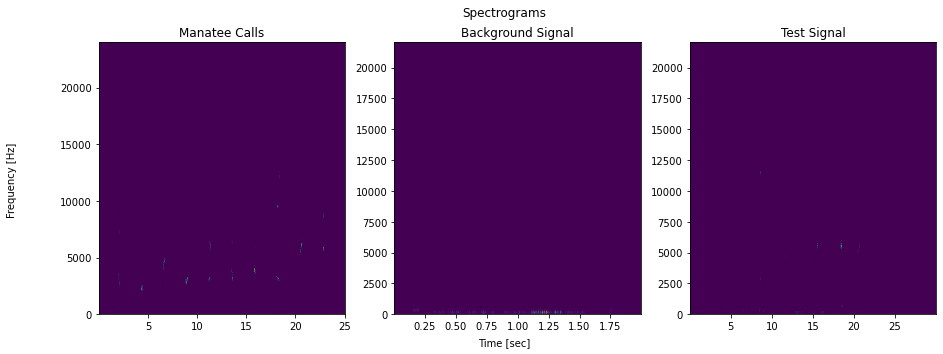

time: 4.92 s (started: 2021-04-11 16:47:46 -04:00)


In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Spectrograms')
fig.text(0.5, 0.04, 'Time [sec]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')

frequencies, times, spectrogram = signal.spectrogram(manatee_signal, manatee_fs)
ax1.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
ax1.set_title('Manatee Calls')

frequencies, times, spectrogram = signal.spectrogram(background_signal, background_fs)
ax2.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
ax2.set_title('Background Signal')


frequencies, times, spectrogram = signal.spectrogram(test_signal, test_fs)
ax3.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
ax3.set_title('Test Signal')

Text(0.5, 1.0, 'Test Signal')

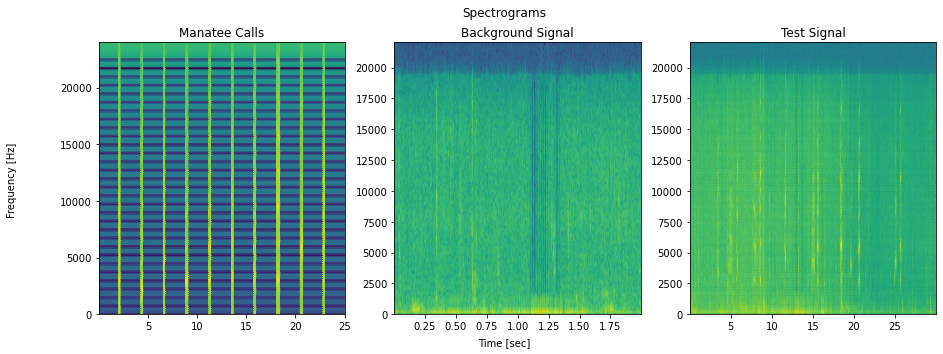

time: 5.16 s (started: 2021-04-11 16:47:41 -04:00)


In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Spectrograms')
fig.text(0.5, 0.04, 'Time [sec]', ha='center')
fig.text(0.04, 0.5, 'Frequency [Hz]', va='center', rotation='vertical')

frequencies, times, spectrogram = signal.spectrogram(manatee_signal, manatee_fs)
ax1.pcolormesh(times, frequencies, 10*np.log10(spectrogram), shading='gouraud')
ax1.set_title('Manatee Calls')

frequencies, times, spectrogram = signal.spectrogram(background_signal, background_fs)
ax2.pcolormesh(times, frequencies, 10*np.log10(spectrogram), shading='gouraud')
ax2.set_title('Background Signal')


frequencies, times, spectrogram = signal.spectrogram(test_signal, test_fs)
ax3.pcolormesh(times, frequencies, 10*np.log10(spectrogram), shading='gouraud')
ax3.set_title('Test Signal')

### Approach 1

#### Define Normalized Least Mean Squares Filter

In [50]:
class NLMS():
    
    def __init__(self, step_size, order):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e

    
class NLMS_MCC():
    
    def __init__(self, step_size, order, sigma):
        self.step_size = step_size
        self.order = order
        self.sigma = sigma
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            # w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            w = w + ((self.step_size / (np.sqrt(2 * np.pi) * self.sigma**3)) * np.exp(-e[i]**2 / (2 * self.sigma**2)) * e[i] * u[i]) #/ norm
            # should we normalize the above?
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e

time: 0 ns (started: 2021-04-11 18:49:08 -04:00)


#### Train Two NLMS_MCC Match Filters
One for the manatee calls signal and one for the background signal

In [94]:
# calculate the appropriate kernel bandwidths using Silverman's bandwidth equation

manatee_sigma = silverman_bandwidth(manatee_signal)
background_sigma = silverman_bandwidth(background_signal)

time: 0 ns (started: 2021-04-11 19:13:50 -04:00)


In [110]:
# determine which filter order produces the highest 

reps = 3
orders = [2, 3, 4, 5, 6]
MSEs_manatee = np.zeros((reps, len(orders)))
MSEs_background = np.zeros((reps, len(orders)))

for i in range(reps):
    for j in range(len(orders)):
        mcc_manatee = NLMS_MCC(step_size=0.8, order=orders[j], sigma=manatee_sigma)
        outputs_manatee, weights_manatee, errors_manatee = mcc_manatee.learn(manatee_signal, manatee_signal)
        MSEs_manatee[i,j] = mse(errors_manatee)

for i in range(reps):
    for j in range(len(orders)):
        mcc_background = NLMS_MCC(step_size=0.8, order=orders[j], sigma=background_sigma)
        outputs_background, weights_background, errors_background = mcc_background.learn(background_signal, background_signal)
        MSEs_background[i,j] = mse(errors_background)
        
manatee_order = orders[np.argmin(MSEs_manatee.mean(axis=0))]
background_order = orders[np.argmin(MSEs_background.mean(axis=0))]

print('Use an order of %s for the manatee filter and an order of %s for the background filter.' % (manatee_order, background_order))

Use an order of 3 for the manatee filter and an order of 2 for the background filter.
time: 5min 33s (started: 2021-04-11 19:27:59 -04:00)


In [127]:
mcc_manatee = NLMS_MCC(step_size=0.01, order=manatee_order, sigma=manatee_sigma)
outputs_manatee, weights_manatee, errors_manatee = mcc_manatee.learn(manatee_signal, manatee_signal)

time: 20.6 s (started: 2021-04-11 19:50:14 -04:00)


Text(0.5, 1.0, 'Manatee Calls Match Filter Output')

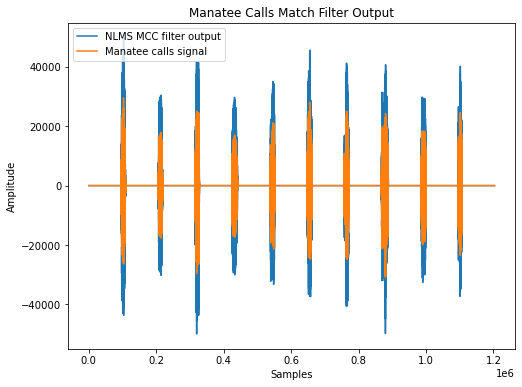

time: 453 ms (started: 2021-04-11 22:09:36 -04:00)


In [137]:
plt.figure(figsize=(8, 6))
plt.plot(outputs_manatee, label='NLMS MCC filter output')
plt.plot(manatee_signal, label='Manatee calls signal')
plt.legend(loc='upper left')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Manatee Calls Match Filter Output')

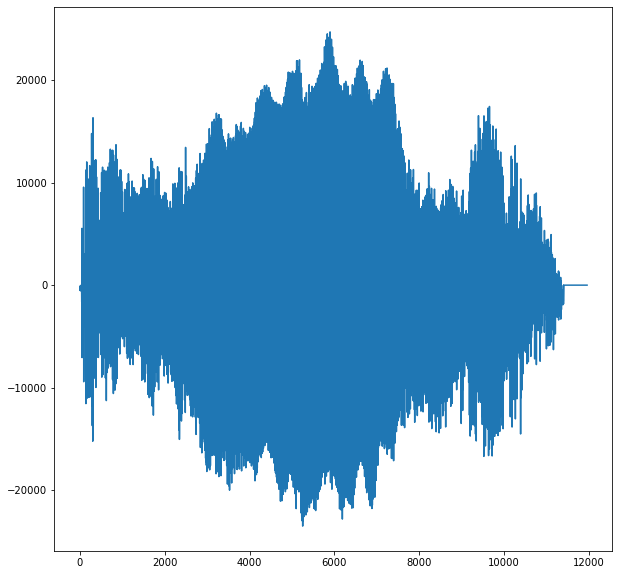

time: 187 ms (started: 2021-04-12 20:25:31 -04:00)


In [573]:
plt.figure(figsize=(10, 10))
plt.plot(manatee_signal[1096043:1108000])

first signal is 96000 to 109158
second signal is 205158 to 218994
third signal is 314994 to 328155
fourth signal is 424155 to 441225
fifth signal is 537225 to 551764
sixth signal is 647764 to 661664
seventh 757664 to 771693
eighth 867693 to 888366
ninth 984366 to 1000043 
tenth 1096043 to 1107446

In [584]:
manatee_signal[1107445:1108000]

array([-174,    0,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1,
          0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,
          1,    0,    1,    0,    1,    0,    1,   

time: 0 ns (started: 2021-04-12 20:26:28 -04:00)


# notes

- make 10 models, training on each manatee calls, get audacity and cut yourself
- make predictions on the test signal with those 10 models
- see if these turn out to be different than the test signal
- think about ensemble...

- label 25 sample bins

- probability estimation of errors.. density estimation for each error gives you the log likelihood, then you do ratio in sprt and cusum

- sprt and cusum are on the same models you use in part a

- winner take all, thresholding, sprt and cusum

- winner take all and thresholding can be on error and pick minimum error
-

- make sure the desired signal is one step ahead

In [129]:
mcc_background = NLMS_MCC(step_size=0.01, order=background_order, sigma=background_sigma)
outputs_background, weights_background, errors_background = mcc_background.learn(background_signal, background_signal)

time: 1.53 s (started: 2021-04-11 19:50:35 -04:00)


Text(0.5, 1.0, 'Background Match Filter Output')

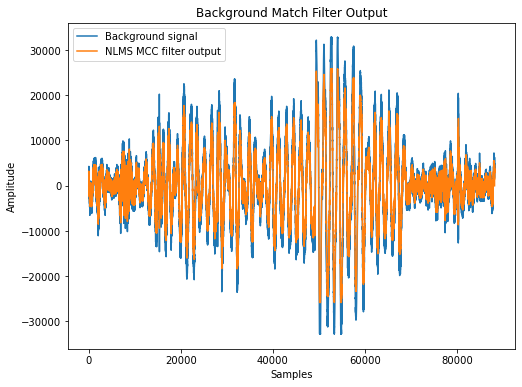

time: 157 ms (started: 2021-04-11 22:09:45 -04:00)


In [138]:
plt.figure(figsize=(8, 6))
plt.plot(background_signal, label='Background signal')
plt.plot(outputs_background, label='NLMS MCC filter output')
plt.legend(loc='upper left')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Background Match Filter Output')

#### Apply Match Filters to Test Signal

In [214]:
# convolve test signal with filter weights
# take the absolute value of that input
# normalize the outputs to be between 0 and 1
# smooth the signal with a bin size of 25

outputs_test_manatee = smoothed_binned(min_max(np.abs(np.convolve(test_signal, weights_manatee[-1]))), 25)
outputs_test_background = smoothed_binned(min_max(np.abs(np.convolve(test_signal, weights_background[-1]))), 25)

outputs_test_background = np.convolve(test_signal, weights_background[-1])

time: 125 ms (started: 2021-04-12 13:46:09 -04:00)


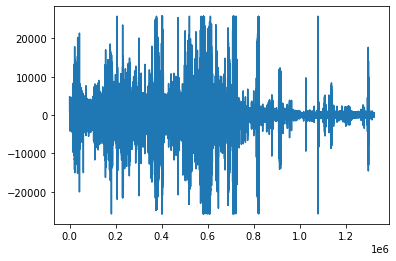

time: 250 ms (started: 2021-04-12 13:46:13 -04:00)


In [215]:
plt.plot(outputs_test_background)

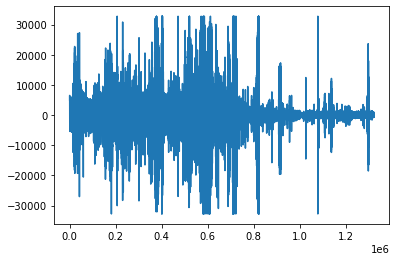

time: 250 ms (started: 2021-04-12 13:46:23 -04:00)


In [216]:
plt.plot(test_signal)

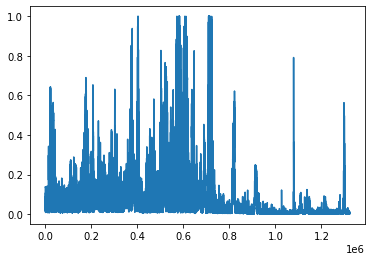

time: 390 ms (started: 2021-04-12 13:32:23 -04:00)


In [213]:
# normalize the outputs
# use min-max normalization
plt.plot(outputs_test_manatee)a


### Approach 2